In [26]:
import os
import pickle
import keras
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Activation, GlobalMaxPooling1D, LSTM, Conv1D, MaxPooling1D, Activation
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import regularizers
from keras import losses
from sklearn.metrics import roc_curve, auc #roc_auc_score as AUC


In [6]:
def load_pickle(file_path, max_bytes = 2**31 - 1):
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

train_raw = load_pickle('train_df_after_preprocessing.pkl')
test_raw = load_pickle('test_df_after_preprocessing.pkl')
valid_raw = load_pickle('valid_df_after_preprocessing.pkl')


In [66]:
y_train = train_raw['click'].values
y_train = y_train.reshape(len(y_train), 1)
x_train = train_raw.drop('click', axis = 1).values
#x_train = x_train.reshape(x_train.shape[0],11, 43)
x_train = x_train.reshape(x_train.shape[0],252, 2)

y_valid = valid_raw['click'].values
y_valid = y_valid.reshape(len(y_valid), 1)
x_valid = valid_raw.drop('click', axis = 1).values
#x_valid = x_valid.reshape(x_valid.shape[0], 11, 43)
x_valid = x_valid.reshape(x_valid.shape[0], 252, 2)

print(y_train.shape)
print(x_train.shape)
print(y_valid.shape)
print(x_valid.shape)


(19723, 1)
(19723, 252, 2)
(303925, 1)
(303925, 252, 2)


In [72]:
MODEL_CHECKPOINT_FILE_PATH='Keras-LSTM.hdf5'

model = Sequential()
BATCH_SIZE = 64
LEARNING_RATE=0.0001
input_dim = x_train.shape[1]
output_dim = y_train.shape[1]
# nb_filter = 250
# filter_length = 3
hidden_dims = 250

#mlp1
# model.add(Dense(32, activation='relu', input_dim=input_dim))
# model.add(Dense(output_dim, activation='sigmoid'))

#mlp2
# model.add(Dense(64, input_dim=input_dim, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(output_dim, activation='sigmoid'))

# lstm
model.add(LSTM(32, return_sequences=True,
               input_shape=(252, 2)))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.2))
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dropout(0.2))
model.add(Dense(output_dim, activation='linear'))

optimizer=Adam(lr=LEARNING_RATE)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 252, 32)           4480      
_________________________________________________________________
dropout_36 (Dropout)         (None, 252, 32)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [74]:
checkpointer = ModelCheckpoint(filepath=MODEL_CHECKPOINT_FILE_PATH, verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

history = model.fit(x_train, y_train,
          epochs=15,
          batch_size=64,
          callbacks=[earlystopper, checkpointer],
          validation_data=(x_valid, y_valid))

# score = model.evaluate(x_valid, y_valid, batch_size=128)
# print(score)

Train on 19723 samples, validate on 303925 samples
Epoch 1/15
19723/19723 [==============================] - 682s 35ms/step - loss: 0.3057 - acc: 0.9091 - val_loss: 0.1120 - val_acc: 0.9993

Epoch 00001: val_loss improved from inf to 0.11199, saving model to Keras-LSTM.hdf5
Epoch 2/15
19723/19723 [==============================] - 688s 35ms/step - loss: 0.3006 - acc: 0.9091 - val_loss: 0.1002 - val_acc: 0.9993

Epoch 00002: val_loss improved from 0.11199 to 0.10019, saving model to Keras-LSTM.hdf5
Epoch 3/15
19723/19723 [==============================] - 661s 34ms/step - loss: 0.3027 - acc: 0.9091 - val_loss: 0.0835 - val_acc: 0.9993

Epoch 00003: val_loss improved from 0.10019 to 0.08348, saving model to Keras-LSTM.hdf5
Epoch 4/15
19723/19723 [==============================] - 653s 33ms/step - loss: 0.3012 - acc: 0.9091 - val_loss: 0.1032 - val_acc: 0.9993

Epoch 00004: val_loss did not improve
Epoch 5/15
19723/19723 [==============================] - 648s 33ms/step - loss: 0.3162 - a

In [75]:
model.load_weights(MODEL_CHECKPOINT_FILE_PATH)
prob_click_train = model.predict(x_train)
prob_click_valid = model.predict(x_valid)


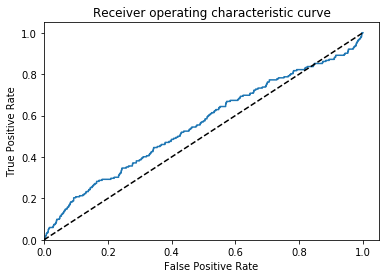

AUC: 0.555622


In [76]:

def roc_results_plot(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    
    plt.show()
    print('AUC: %f' % roc_auc)

roc_results_plot(y_valid,prob_click_valid)
